In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D
from keras.layers.advanced_activations import ELU, ReLU
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import os

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
!pwd

/content


In [4]:
!ls

drive  sample_data


In [0]:
!mkdir github_data

In [6]:
!cd github_data && git clone https://github.com/pszajows/plane3d_data_for_DL.git

Cloning into 'plane3d_data_for_DL'...
remote: Enumerating objects: 10020, done.
remote: Total 10020 (delta 0), reused 0 (delta 0), pack-reused 10020
Receiving objects: 100% (10020/10020), 783.51 MiB | 34.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


In [7]:
!ls github_data

plane3d_data_for_DL


In [0]:
folder = "/content/github_data/plane3d_data_for_DL"

In [0]:
os.chdir(folder)

In [10]:
!pwd

/content/github_data/plane3d_data_for_DL


In [11]:
!ls

plane_data.csv	README.md  test  train


In [0]:
lista_obrazow = pd.read_csv("plane_data.csv", sep=";")

In [13]:
lista_obrazow.head()

,folder,filename,angle
0,train,samolot00001.png,-45.000000
1,train,samolot00003.png,-44.774989
2,train,samolot00005.png,-44.549978
3,train,samolot00007.png,-44.324966
4,train,samolot00009.png,-44.099955


In [14]:
lista_obrazow.shape

(10000, 3)

In [15]:
liczba_obrazow_treningowych = lista_obrazow[lista_obrazow["folder"]=="train"].shape[0]
liczba_obrazow_treningowych

9600

In [16]:
liczba_obrazow_testowych = lista_obrazow[lista_obrazow["folder"]=="test"].shape[0]
liczba_obrazow_testowych

400

In [17]:
obrazek = cv2.imread(os.path.join(lista_obrazow["folder"].iloc[0], lista_obrazow["filename"].iloc[0]))
obrazek.shape

(224, 224, 3)

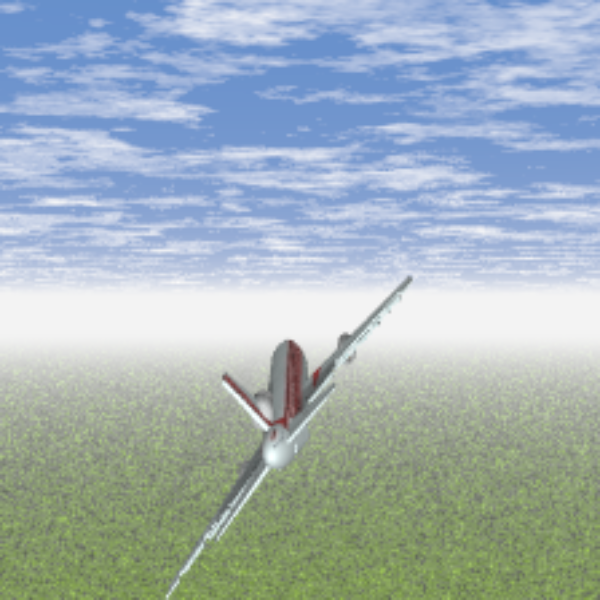

In [18]:
obrazek = cv2.resize(obrazek, (600,600))
cv2_imshow(obrazek)

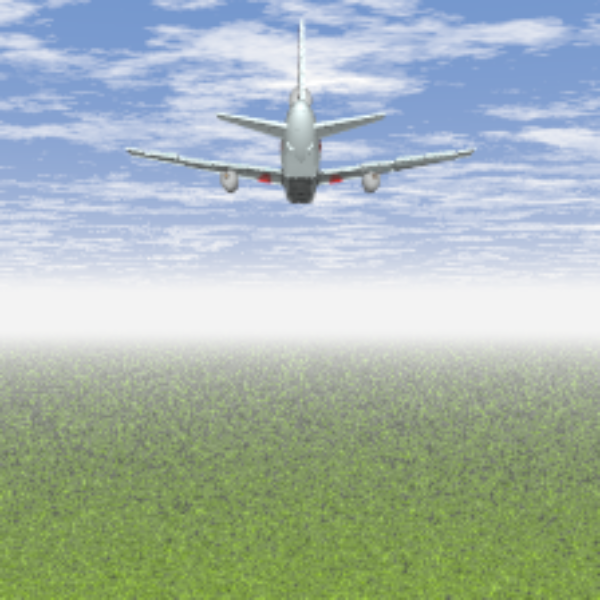

In [19]:
obrazek = cv2.imread(os.path.join(lista_obrazow["folder"].iloc[9000], lista_obrazow["filename"].iloc[9000]))
obrazek = cv2.resize(obrazek, (600,600))
cv2_imshow(obrazek)

In [20]:
lista_obrazow["angle"].iloc[9000]

0.101255063

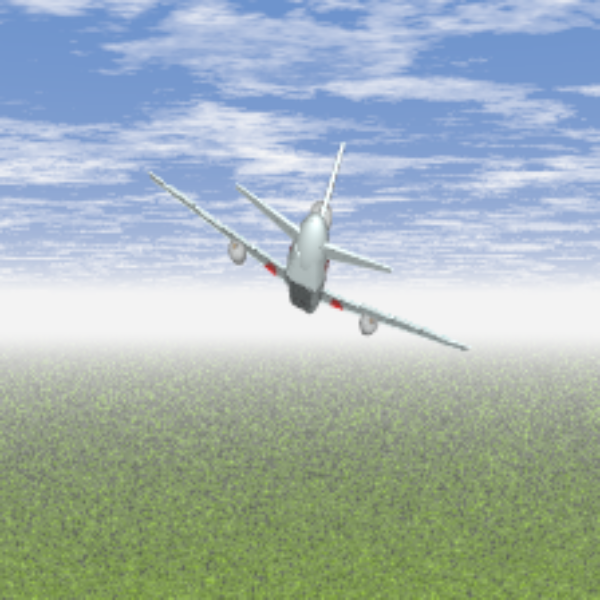

In [21]:
obrazek = cv2.imread(os.path.join(lista_obrazow["folder"].iloc[5500], lista_obrazow["filename"].iloc[5500]))
obrazek = cv2.resize(obrazek, (600,600))
cv2_imshow(obrazek)

In [22]:
lista_obrazow["angle"].iloc[5500]

22.56187809

In [23]:
y_train=[]
y_test=[]
X_train = np.empty(liczba_obrazow_treningowych*224*224*3,dtype=np.uint8).reshape(liczba_obrazow_treningowych,224,224,3)
X_test = np.empty(liczba_obrazow_testowych*224*224*3,dtype=np.uint8).reshape(liczba_obrazow_testowych,224,224,3)

for i in range(lista_obrazow.shape[0]):
  if i%100==0:
    print("#",end="")
  obrazek = cv2.imread(os.path.join(lista_obrazow["folder"].iloc[i],lista_obrazow["filename"].iloc[i]))
  obrazek_tensor = np.array(obrazek).astype(np.uint8).reshape(1,224,224,3)
  if lista_obrazow["folder"].iloc[i] == "train":
    y_train.append(lista_obrazow["angle"].iloc[i])
    X_train[len(y_train)-1,:,:,:] = obrazek_tensor 
  else:
    y_test.append(lista_obrazow["angle"].iloc[i])
    X_test[len(y_test)-1,:,:,:] = obrazek_tensor
print()
(len(y_train), len(y_test))

####################################################################################################


(9600, 400)

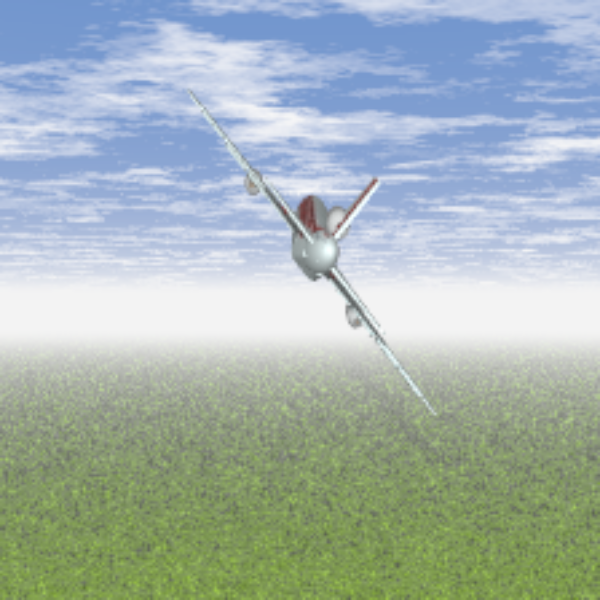

In [24]:
obrazek = X_test[398,:,:,:].reshape(224,224,3)
obrazek = cv2.resize(obrazek, (600,600))
cv2_imshow(obrazek)

In [0]:
os.chdir("/content/drive/My Drive")

In [26]:
!pwd

/content/drive/My Drive


In [27]:
model = Sequential()
model.add(Convolution2D(8, 2, 2, input_shape=(224, 224, 3))) 
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1)) 
model.compile(optimizer="adam", loss="mse")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (2, 2), input_shape=(224, 224,...)`
  


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.wlasny1_chkpnt.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')

In [29]:
historia = model.fit(X_train, y_train, batch_size = 32, epochs=100, validation_split=0.1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])



Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 9s 1ms/step - loss: 302175.7535 - val_loss: 1609.8237
Epoch 2/100
8640/8640 [==============================] - 8s 924us/step - loss: 11645.1266 - val_loss: 5554.7223
Epoch 3/100
8640/8640 [==============================] - 8s 935us/step - loss: 8849.0252 - val_loss: 1542.8658
Epoch 4/100
8640/8640 [==============================] - 8s 927us/step - loss: 7065.7850 - val_loss: 741.3225
Epoch 5/100
8640/8640 [==============================] - 8s 931us/step - loss: 4904.5889 - val_loss: 285.6942
Epoch 6/100
8640/8640 [==============================] - 8s 934us/step - loss: 4312.3880 - val_loss: 302.1468
Epoch 7/100
8640/8640 [==============================] - 8s 925us/step - loss: 2609.6377 - val_loss: 344.1266
Epoch 8/100
8640/8640 [==============================] - 8s 923us/step - loss: 1849.4591 - val_loss: 3699.8019

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001000

In [0]:
model.save("wlasny1.hd5")

In [31]:
model.evaluate(X_test, y_test)

400/400 [==============================] - 0s 536us/step


177.41842628479003

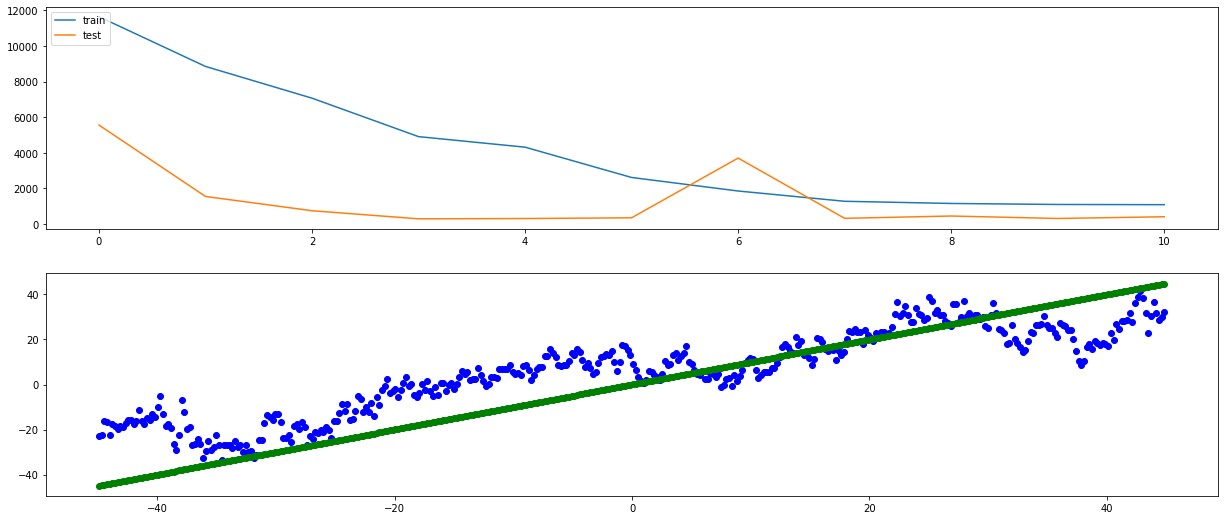

In [32]:
def wizualizuj_wyniki(historia, model):
  plt.rcParams["figure.figsize"] = (21,9)
  fig, (wyk1, wyk2) = plt.subplots(nrows=2, ncols=1)
  wyk1.plot(historia.history['loss'][1:])
  wyk1.plot(historia.history['val_loss'][1:])
  wyk1.legend(['train', 'test'], loc='upper left')

  bledy = []
  for i in range(400):
    x = model.predict(X_test[i,:,:,:].reshape(1,224,224,3))[0][0]
    bledy.append([y_test[i],np.abs(x-y_test[i]),x])

  bledy = np.array(bledy)
  wyk2.scatter(bledy[:,0],bledy[:,2],c='b')
  wyk2.scatter(bledy[:,0],bledy[:,0],c='g')

wizualizuj_wyniki(historia, model)

In [33]:
model2 = Sequential()
model2.add(Convolution2D(8, 2, 2, input_shape=(224, 224, 3))) 
model2.add(ReLU())
model2.add(MaxPooling2D(pool_size=(8, 8)))
model2.add(Convolution2D(8, 3, 3)) 
model2.add(ReLU())
model2.add(Flatten())
model2.add(Dropout(0.6))
model2.add(Dense(512)) 
model2.add(ELU())
model2.add(Dense(1)) 
model2.compile(optimizer="adam", loss="mse")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (2, 2), input_shape=(224, 224,...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3))`
  """


In [34]:
mcp_save = ModelCheckpoint('.wlasny2_chkpnt.hdf5', save_best_only=True, monitor='val_loss', mode='min')
historia = model2.fit(X_train, y_train, batch_size = 32, epochs=100, validation_split=0.1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])

Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 9s 1ms/step - loss: 51314.0671 - val_loss: 535.6943
Epoch 2/100
8640/8640 [==============================] - 9s 1ms/step - loss: 238.4564 - val_loss: 253.7351
Epoch 3/100
8640/8640 [==============================] - 9s 1ms/step - loss: 93.8292 - val_loss: 215.2298
Epoch 4/100
8640/8640 [==============================] - 9s 1ms/step - loss: 53.4181 - val_loss: 202.9085
Epoch 5/100
8640/8640 [==============================] - 9s 1ms/step - loss: 38.1505 - val_loss: 177.6664
Epoch 6/100
8640/8640 [==============================] - 9s 1ms/step - loss: 28.5600 - val_loss: 136.2145
Epoch 7/100
8640/8640 [==============================] - 9s 1ms/step - loss: 23.9850 - val_loss: 111.9449
Epoch 8/100
8640/8640 [==============================] - 9s 1ms/step - loss: 20.7170 - val_loss: 104.0391
Epoch 9/100
8640/8640 [==============================] - 9s 1ms/step - loss: 18.3643 - val_loss: 97.9

In [0]:
model2.save("wlasny2.hd5")

In [36]:
model2.evaluate(X_test, y_test)

400/400 [==============================] - 0s 497us/step


3.556675200462341

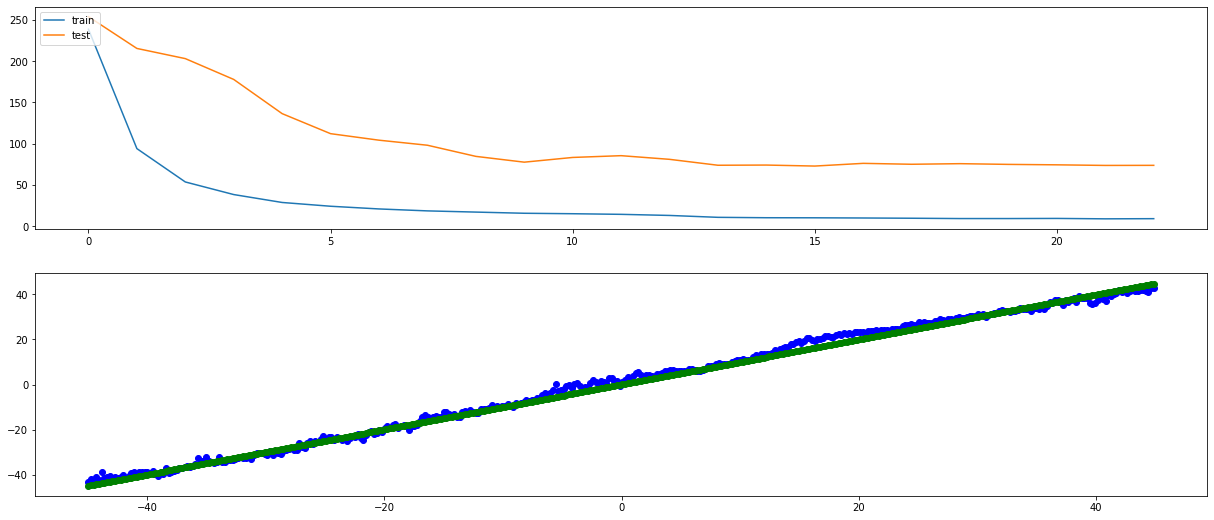

In [37]:
wizualizuj_wyniki(historia, model2)

In [0]:
model_MobileNet = MobileNet(weights='imagenet')

In [0]:
obrazek = image.load_img(os.path.join("/content/github_data/plane3d_data_for_DL",lista_obrazow["folder"].iloc[0], lista_obrazow["filename"].iloc[0]), target_size=(224, 224))
x = image.img_to_array(obrazek)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [40]:
preds = model_MobileNet.predict(x)
print(decode_predictions(preds, top=4))

[[('n04592741', 'wing', 0.33141896), ('n04552348', 'warplane', 0.26241633), ('n04008634', 'projectile', 0.056197483), ('n02690373', 'airliner', 0.047015738)]]


In [41]:
model_MobileNet_topless = MobileNet(include_top = False, pooling = "max", weights='imagenet')
x = model_MobileNet_topless.output
x = Dense(1, activation = "linear") (x)
model_tl = Model(input = model_MobileNet_topless.input,outputs=x)
for layer in model_tl.layers[:-1]:
  layer.trainable = False
model_tl.compile(optimizer = "adam", loss = "mse")

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.


In [42]:
mcp_save = ModelCheckpoint('.MobileNet_tl_chkpnt.hdf5', save_best_only=True, monitor='val_loss', mode='min')
historia = model_tl.fit(X_train, y_train, batch_size = 32, epochs=5, validation_split=0.1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])

Train on 8640 samples, validate on 960 samples
Epoch 1/5
8640/8640 [==============================] - 25s 3ms/step - loss: 611.1371 - val_loss: 826.0289
Epoch 2/5
8640/8640 [==============================] - 24s 3ms/step - loss: 476.5739 - val_loss: 835.3730
Epoch 3/5
8640/8640 [==============================] - 24s 3ms/step - loss: 376.2998 - val_loss: 853.3190
Epoch 4/5
8640/8640 [==============================] - 24s 3ms/step - loss: 314.5598 - val_loss: 869.3468

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/5
8640/8640 [==============================] - 24s 3ms/step - loss: 280.9543 - val_loss: 871.4411


In [0]:
model_tl.save("MobileNet_tl_posredni.hd5")

In [44]:
model_tl.evaluate(X_test, y_test)

400/400 [==============================] - 1s 3ms/step


868.4470974731445

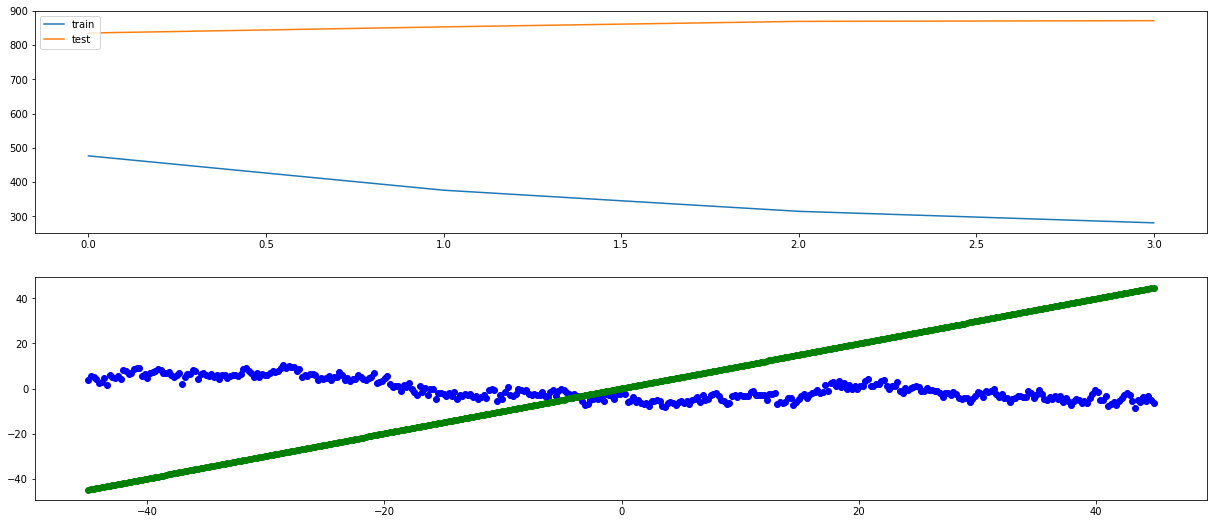

In [45]:
wizualizuj_wyniki(historia, model_tl)

In [0]:
for layer in model_tl.layers[:-1]:
  layer.trainable = True
model_tl.compile(optimizer = "adam", loss = "mse")

In [0]:
K.set_value(model.optimizer.lr, 0.000001)

In [48]:
mcp_save = ModelCheckpoint('.MobileNet_tl_chkpnt.hdf5', save_best_only=True, monitor='val_loss', mode='min')
historia = model_tl.fit(X_train, y_train, batch_size = 32, epochs=5, validation_split=0.1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])

Train on 8640 samples, validate on 960 samples
Epoch 1/5
8640/8640 [==============================] - 99s 12ms/step - loss: 18.3333 - val_loss: 21.8936
Epoch 2/5
8640/8640 [==============================] - 95s 11ms/step - loss: 2.2222 - val_loss: 9.1965
Epoch 3/5
8640/8640 [==============================] - 94s 11ms/step - loss: 1.4365 - val_loss: 10.7227
Epoch 4/5
8640/8640 [==============================] - 94s 11ms/step - loss: 0.9544 - val_loss: 8.1372
Epoch 5/5
8640/8640 [==============================] - 95s 11ms/step - loss: 0.7519 - val_loss: 10.4187


In [0]:
model_tl.save("MobileNet_tl_koncowy.hd5")

In [50]:
model_tl.evaluate(X_test, y_test)

400/400 [==============================] - 1s 3ms/step


0.844118392765522

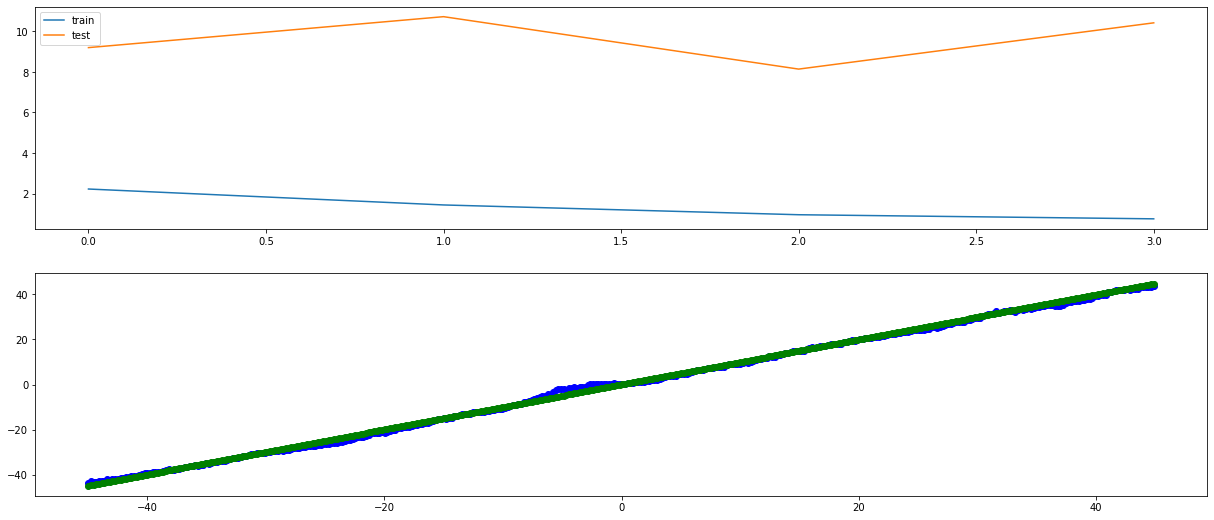

In [51]:
wizualizuj_wyniki(historia, model_tl)


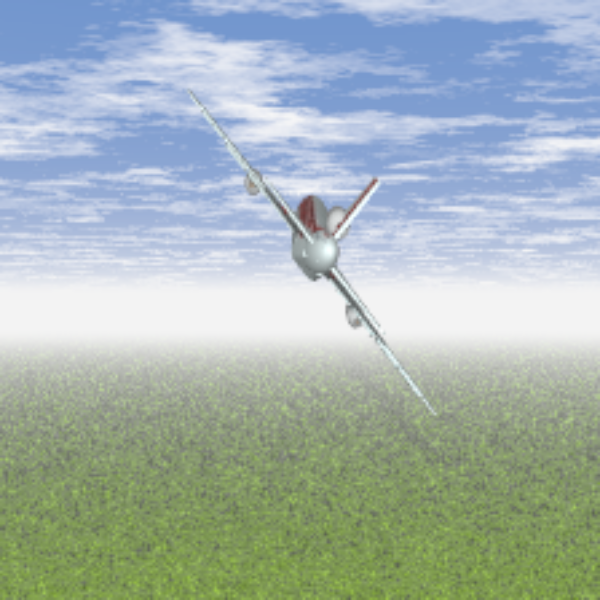

In [52]:
obrazek = X_test[398,:,:,:].reshape(224,224,3)
cv2_imshow(cv2.resize(obrazek, (600,600)))

In [53]:
y_test[398]

44.6219811

In [54]:
model_tl.predict(obrazek.reshape(1,224,224,3))

array([[43.39725]], dtype=float32)

In [0]:
!rm -r /content/github_data